# 0. Install libraries

In [ ]:
!pip install -q ultralytics==8.3.19
!pip install -q supervision[assets]==0.25.1

# Import necessary libraries
import os
import numpy as np
import supervision as sv  # Library for processing YOLO outputs
import ultralytics
from ultralytics import YOLO
from IPython import display

# Clear the output disolay to keep the notebook clean
display.clear_output()

# # Check system compatibility and environment for ultralytics
ultralytics.checks()

# Print the installed version of the supervision library
print("supervision.__version__: ", sv.__version__)

# Get and print the current working directory
HOME = os.getcwd()
print("HOME:", HOME)

Ultralytics 8.3.19 🚀 Python-3.12.11 torch-2.8.0+cu126 CPU (Intel Xeon 2.20GHz)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 39.4/107.7 GB disk)
supervision.__version__:  0.25.1
HOME: /content


# 1. Download sample video and best.pt

In [ ]:
!pip install -q gdown

# Download vehicle_counting.mp4
!gdown 1-aU7nzJz7fuunjT-hwjY9MwodyExUWUi

Downloading...
From: https://drive.google.com/uc?id=1-aU7nzJz7fuunjT-hwjY9MwodyExUWUi
To: /content/vehicle_counting.mp4
100% 74.6M/74.6M [00:01<00:00, 54.3MB/s]


In [ ]:
SOURCE_VIDEO_PATH = f"{HOME}/vehicle_counting.mp4"
print(SOURCE_VIDEO_PATH)

/content/vehicle_counting.mp4


# 2. Load best.pt file and configure the identity object

In [ ]:
# Download best.pt
!gdown 1EPdPKw0wOiW1C6eHcByVI27_1G2Jz3ys

Downloading...
From: https://drive.google.com/uc?id=1EPdPKw0wOiW1C6eHcByVI27_1G2Jz3ys
To: /content/best.pt
100% 6.23M/6.23M [00:00<00:00, 141MB/s]


In [ ]:
# Load best.pt
model = YOLO("/content/best.pt")

# Retrieve the dictionary mapping class IDs to class names from the model
CLASS_NAMES_DICT = model.model.names

# Define the selected class names for filtering detections
SELECTED_CLASS_NAMES = ["motorbike", "car", "bus", "truck"]
SELECTED_CLASS_IDS = [
    {value: key for key, value in CLASS_NAMES_DICT.items()}[class_name] # Reverse lookup frome name to ID
    for class_name in SELECTED_CLASS_NAMES
]
print("Selected IDs:", SELECTED_CLASS_IDS, [CLASS_NAMES_DICT[i] for i in SELECTED_CLASS_IDS])

Selected IDs: [0, 1, 2, 3] ['motorbike', 'car', 'bus', 'truck']


# 3. Predict and annotate a single frame

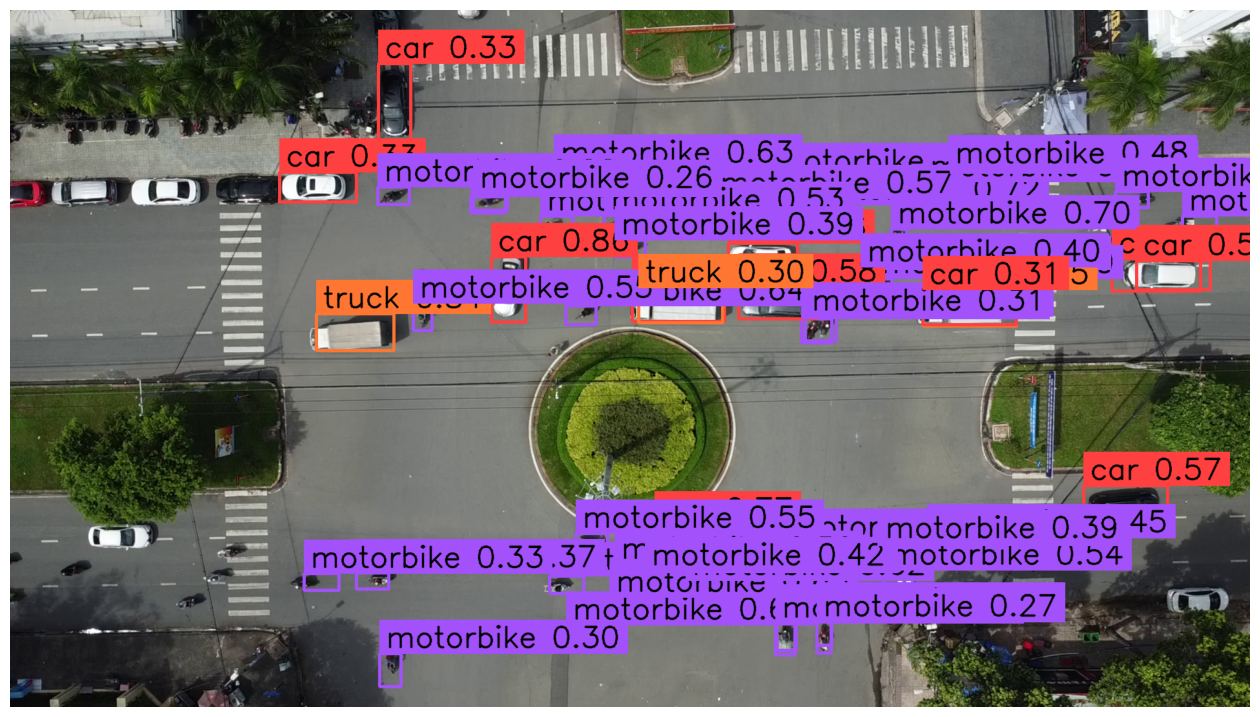

In [ ]:
# Generate frames from the input video file
generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)

# Create an instance of BoxAnnotator for drawing bounding boxes
box_annotator = sv.BoxAnnotator(thickness=4)

# Create an instance of LabelAnnotator of displaying labels on detections
label_annotator = sv.LabelAnnotator(text_thickness=2, text_scale=1.5, text_color=sv.Color.BLACK)

# Initialize the frame iterator from the video frame generator
iterator = iter(generator)

# Retrieve the first frame from the video
frame = next(iterator)

# Run the best.pt model on the frame to detect objects
results = model(frame, verbose=False)[0]

# Convert best.pt detection results to a Supervision Detections object
detections = sv.Detections.from_ultralytics(results)

# Filter detections to keep only the selected class IDs (car, motorcycle, bus, truck, bicycle)
detections = detections[np.isin(detections.class_id, SELECTED_CLASS_IDS)]

# Generate labels for detected objects in the format "class_name confidence"
labels = [
    f"{CLASS_NAMES_DICT[class_id]} {confidence:0.2f}"
    for confidence, class_id in zip(detections.confidence, detections.class_id)
]

# Create a copy of the frame to apply annotations
annotated_frame = frame.copy()

# Draw bounding boxes on the detected objects
annotated_frame = box_annotator.annotate(scene=annotated_frame, detections=detections)

# Draw labels for the detected objects
annotated_frame = label_annotator.annotate(scene=annotated_frame, detections=detections, labels=labels)

# Display the annotated frame with bounding boxes and labels
sv.plot_image(annotated_frame, (16, 16))

# 4. Predict and annotate vehicle_counting.mp4 video using ByteTRACK

## 4.1. Import libraries and inilizate ByteTRACK

In [ ]:
import cv2
import numpy as np
import pandas as pd
import supervision as sv
from collections import defaultdict
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

# Khởi tạo ByteTracker
byte_tracker = sv.ByteTrack(
    track_activation_threshold=0.25,
    lost_track_buffer=30,
    minimum_matching_threshold=0.8,
    frame_rate=30,
    minimum_consecutive_frames=3
)
byte_tracker.reset()

# Lấy kích thước video để quy đổi từ tỉ lệ -> pixel
video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
W, H, FPS = video_info.width, video_info.height, max(1, int(round(video_info.fps or 30)))

def P(px, py):
    return (int(px * W), int(py * H))

def rect_frac(l, t, r, b):
    return [P(l, t), P(r, t), P(r, b), P(l, b)]

## 4.2. Define ROI and colors

In [ ]:
REGIONS_FRACTION = {
    "1": rect_frac(0.01, 0.28, 0.22, 0.9),
    "2": rect_frac(0.3, 0.01, 0.78, 0.22),
    "3": rect_frac(0.8, 0.22, 0.99, 0.85),
    "4": rect_frac(0.23, 0.88, 0.72, 0.99),
}

REGION_COLORS = {
    "normal": sv.Color(r=255, g=0, b=0),
    "active": sv.Color(r=0, g=255, b=0),
}

region_names = ["1","2","3","4"]
zones, zone_annots = [], []

class CustomPolygonZoneAnnotator:
    def __init__(self, zone, color, thickness=4, text_thickness=2, text_scale=2):
        self.zone = zone
        self.color = color
        self.thickness = thickness
        self.text_thickness = text_thickness
        self.text_scale = text_scale

    def annotate(self, scene, color_override=None):
        color = color_override if color_override else self.color
        cv2.polylines(scene, [self.zone.polygon], True, color.as_bgr(), self.thickness)
        return scene

for name in region_names:
    poly = np.array(REGIONS_FRACTION[name], dtype=np.int32)
    zone = sv.PolygonZone(polygon=poly)
    zones.append(zone)
    zone_annot = CustomPolygonZoneAnnotator(zone=zone, color=REGION_COLORS["normal"])
    zone_annots.append(zone_annot)

## 4.3. Define flow variables

In [ ]:
region_total_counts = [defaultdict(int) for _ in zones]
region_present_ids = [set() for _ in zones]
region_active_frames = [0 for _ in zones]
ACTIVE_DURATION = 30

# Biến mới cho tính lưu lượng
flow_data = []  # Lưu dữ liệu lưu lượng theo thời gian
time_windows = []  # Các cửa sổ thời gian
current_flow_counts = [defaultdict(int) for _ in zones]  # Đếm trong khoảng thời gian hiện tại
flow_start_time = 0  # Thời gian bắt đầu tính lưu lượng
FLOW_INTERVAL = 60  # Tính lưu lượng mỗi 60 giây (có thể điều chỉnh)

CLASS_ID_TO_NAME = {cid: model.model.names[cid] for cid in SELECTED_CLASS_IDS}
CLASS_ORDER = [CLASS_ID_TO_NAME[cid] for cid in SELECTED_CLASS_IDS]

LOG_ROWS = []

## 4.4. Show ROI positions

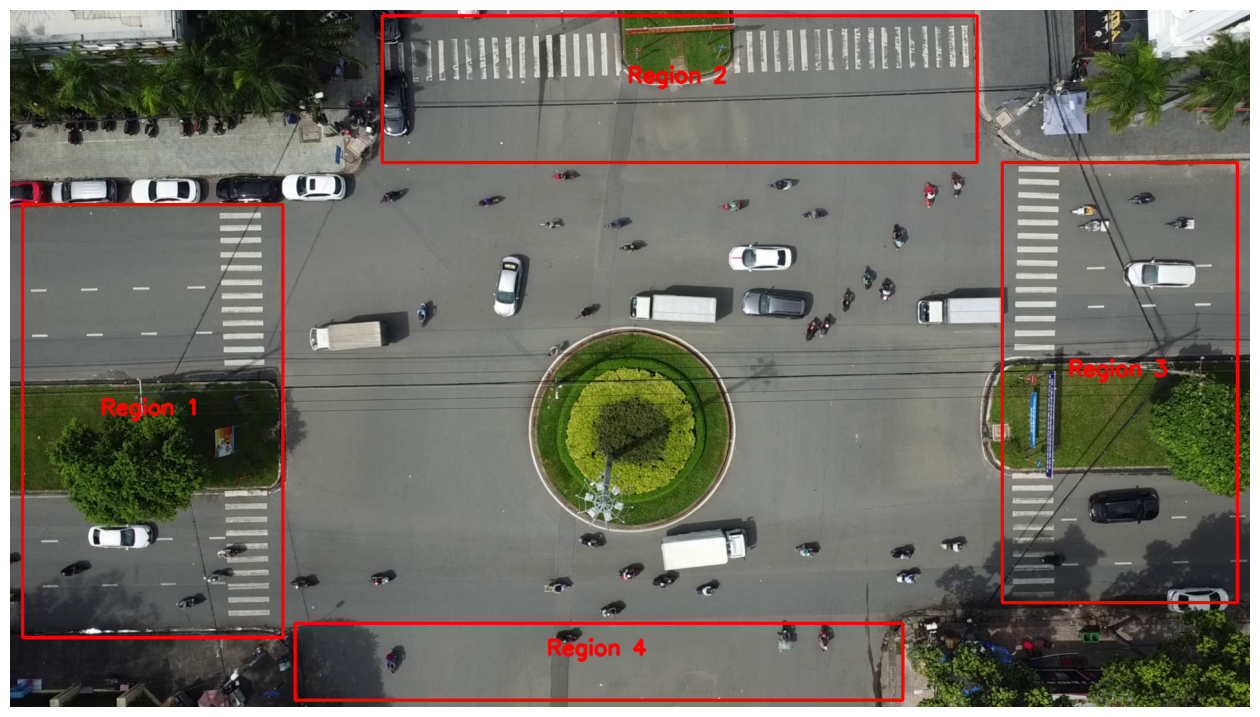

In [ ]:
frame0 = next(iter(sv.get_video_frames_generator(SOURCE_VIDEO_PATH))).copy()
for name in region_names:
    cv2.polylines(frame0, [np.array(REGIONS_FRACTION[name], dtype=np.int32)], True, (0,0,255), 4)
    poly = np.array(REGIONS_FRACTION[name], dtype=np.float32)
    cx, cy = poly.mean(axis=0).astype(int)
    cv2.putText(frame0, f"Region {name}", (cx-80, cy-10), cv2.FONT_HERSHEY_SIMPLEX, 1.1, (0,0,255), 3, cv2.LINE_AA)
sv.plot_image(frame0, (16, 16))

## 4.5. Define Callback function

In [ ]:
trace_annotator = sv.TraceAnnotator(thickness=4, trace_length=50)
box_annotator = sv.BoxAnnotator(thickness=4)
label_annotator = sv.LabelAnnotator(text_thickness=1, text_scale=0.6, text_color=sv.Color.BLACK)

def callback_regions(frame: np.ndarray, index: int) -> np.ndarray:
    global flow_start_time, current_flow_counts

    # Tính thời gian hiện tại
    current_time = index / FPS

    # Detect và track
    results = model(frame, verbose=False)[0]
    det = sv.Detections.from_ultralytics(results)
    det = det[np.isin(det.class_id, SELECTED_CLASS_IDS)]
    det = byte_tracker.update_with_detections(det)

    # Vẽ bbox/trace/label
    annotated = frame.copy()
    labels = [f"#{tid} {model.model.names[c]} {p:.2f}"
              for p, c, tid in zip(det.confidence, det.class_id, det.tracker_id)]
    annotated = trace_annotator.annotate(annotated, det)
    annotated = box_annotator.annotate(annotated, det)
    annotated = label_annotator.annotate(annotated, det, labels=labels)

    # Xử lý từng vùng
    for zi, zone in enumerate(zones):
        inside_mask = zone.trigger(det)
        new_entries_this_frame = False

        # Kiểm tra đối tượng mới vào vùng
        for k, inside in enumerate(inside_mask):
            tid = det.tracker_id[k]
            if tid is None:
                continue

            if inside:
                if tid not in region_present_ids[zi]:
                    # ĐỐI TƯỢNG MỚI VÀO VÙNG - ĐẾM VÀ KÍCH HOẠT
                    region_present_ids[zi].add(tid)
                    cid = det.class_id[k]
                    region_total_counts[zi][cid] += 1
                    current_flow_counts[zi][cid] += 1  # Đếm cho lưu lượng
                    new_entries_this_frame = True
                    region_active_frames[zi] = ACTIVE_DURATION

        # Kiểm tra và tính lưu lượng theo khoảng thời gian
        if current_time - flow_start_time >= FLOW_INTERVAL:
            # Lưu dữ liệu lưu lượng
            flow_record = {
                "timestamp": current_time,
                "time_str": str(timedelta(seconds=int(current_time))),
                "interval": FLOW_INTERVAL
            }

            for zi, region_name in enumerate(region_names):
                total_flow = sum(current_flow_counts[zi].values())
                flow_record[f"region_{region_name}_total"] = total_flow
                flow_record[f"region_{region_name}_flow_per_min"] = total_flow * (60 / FLOW_INTERVAL)

                # Lưu lưu lượng theo từng loại phương tiện
                for cid in SELECTED_CLASS_IDS:
                    class_name = CLASS_ID_TO_NAME[cid]
                    count = current_flow_counts[zi][cid]
                    flow_record[f"region_{region_name}_{class_name}"] = count
                    flow_record[f"region_{region_name}_{class_name}_per_min"] = count * (60 / FLOW_INTERVAL)

            flow_data.append(flow_record)
            time_windows.append(current_time)

            # Reset bộ đếm lưu lượng
            current_flow_counts = [defaultdict(int) for _ in zones]
            flow_start_time = current_time

        # Giảm counter active frames
        if region_active_frames[zi] > 0:
            region_active_frames[zi] -= 1

        # Xác định màu cho vùng
        current_color = REGION_COLORS["active"] if region_active_frames[zi] > 0 else REGION_COLORS["normal"]

        # Vẽ polygon với màu phù hợp
        annotated = zone_annots[zi].annotate(annotated, color_override=current_color)

        # Vẽ thông tin thống kê
        poly = np.array(REGIONS_FRACTION[region_names[zi]], dtype=np.float32)
        cx, cy = poly.mean(axis=0).astype(int)
        occ = getattr(zone, "current_count", int(np.sum(inside_mask)))

        # Tính lưu lượng hiện tại (phút)
        current_flow_per_min = sum(current_flow_counts[zi].values()) * (60 / FLOW_INTERVAL)

        # Tạo text với màu tương ứng
        text_color = (0, 255, 0) if region_active_frames[zi] > 0 else (0, 0, 255)

        # Vẽ text thông tin (bao gồm lưu lượng)
        cv2.putText(annotated, f"Region {region_names[zi]}  Occ:{occ}", (cx-170, cy+30),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.9, text_color, 4, cv2.LINE_AA)

        cv2.putText(annotated, f"Flow: {current_flow_per_min:.1f}/min", (cx-170, cy+60),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.9, text_color, 4, cv2.LINE_AA)

        summary = " | ".join([f"{CLASS_ID_TO_NAME[cid]}:{region_total_counts[zi][cid]}"
                             for cid in SELECTED_CLASS_IDS])
        cv2.putText(annotated, summary, (cx-220, cy+90),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.9, text_color, 4, cv2.LINE_AA)

        # Ghi log
        row = {
            "frame": index,
            "time_s": round(index / FPS, 3),
            "region": region_names[zi],
            "occupancy": int(occ),
            "current_flow_per_min": current_flow_per_min,
            "new_entry": int(new_entries_this_frame)
        }
        for cid in SELECTED_CLASS_IDS:
            row[f"count_{CLASS_ID_TO_NAME[cid]}"] = int(region_total_counts[zi][cid])
        LOG_ROWS.append(row)

    return annotated

## 4.6. Process video

In [ ]:
TARGET_VIDEO_PATH_4R = f"{HOME}/vehicle_counting_4regions_with_flow.mp4"
sv.process_video(
    source_path=SOURCE_VIDEO_PATH,
    target_path=TARGET_VIDEO_PATH_4R,
    callback=callback_regions
)

# 5. Save result and analysis

In [ ]:
csv_path = f"{HOME}/region4_counts_with_flow.csv"
pd.DataFrame(LOG_ROWS).to_csv(csv_path, index=False)

flow_df = pd.DataFrame(flow_data)
flow_csv_path = f"{HOME}/traffic_flow_analysis.csv"
flow_df.to_csv(flow_csv_path, index=False)

print("Saved video:", TARGET_VIDEO_PATH_4R)
print("Saved detailed CSV:", csv_path)
print("Saved flow analysis CSV:", flow_csv_path)

Saved video: /content/vehicle_counting_4regions_with_flow.mp4
Saved detailed CSV: /content/region4_counts_with_flow.csv
Saved flow analysis CSV: /content/traffic_flow_analysis.csv


# 6. Draw traffic flow chart

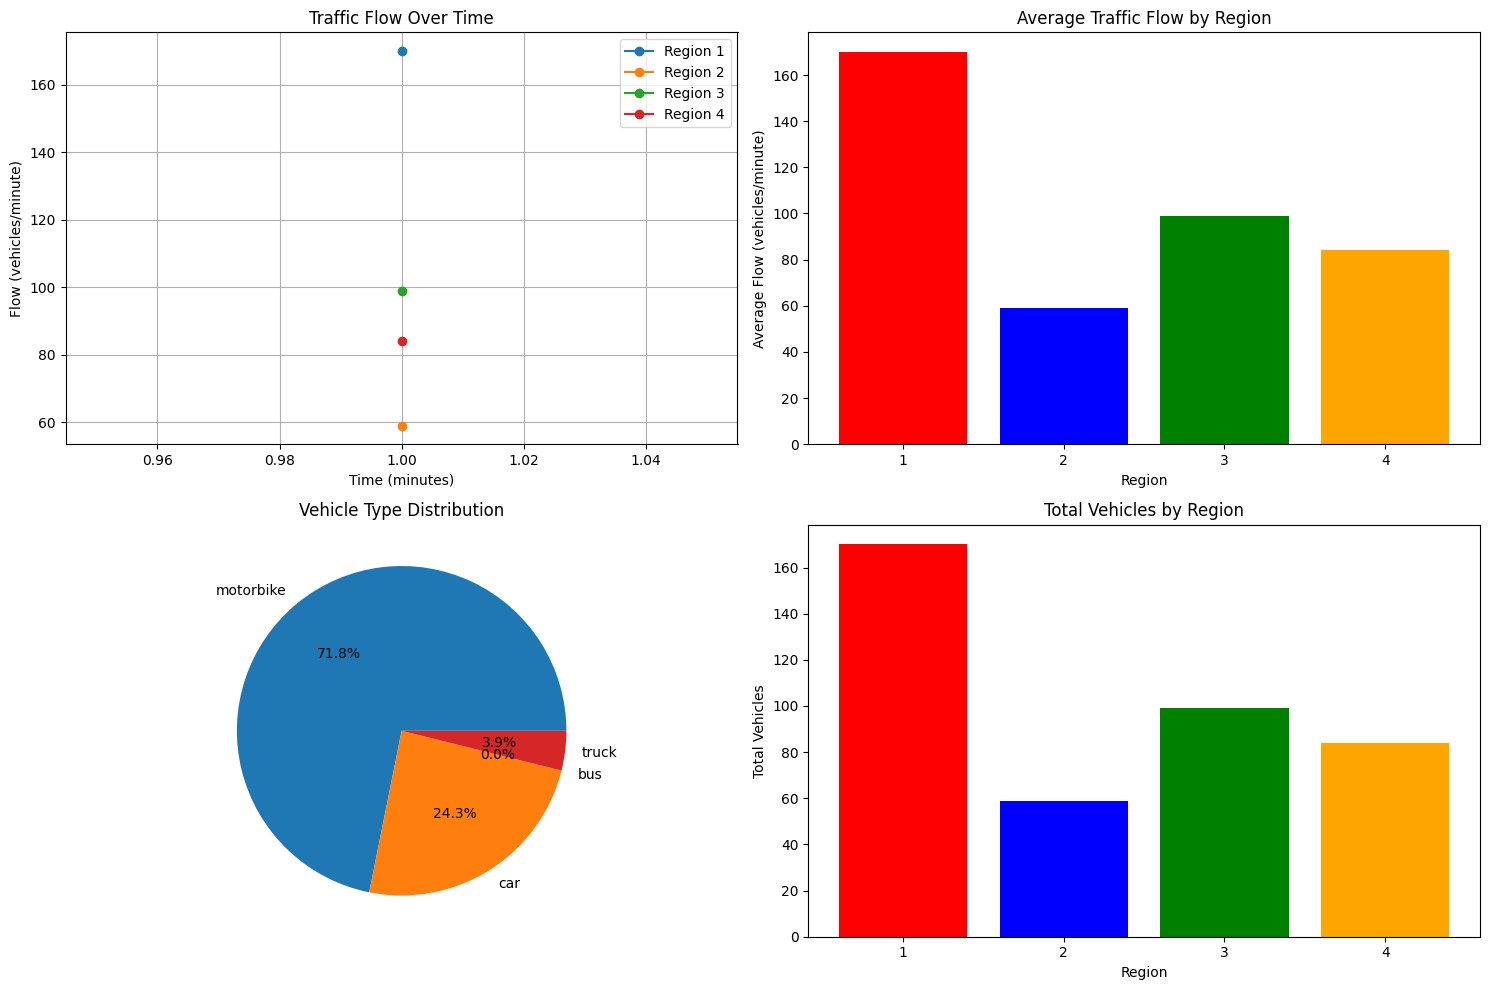

In [ ]:
if len(flow_data) > 0:
    plt.figure(figsize=(15, 10))

    # Biểu đồ tổng lưu lượng theo thời gian
    plt.subplot(2, 2, 1)
    for region in region_names:
        flows = [x[f"region_{region}_flow_per_min"] for x in flow_data]
        times = [x["timestamp"] / 60 for x in flow_data]  # Chuyển sang phút
        plt.plot(times, flows, marker='o', label=f'Region {region}')
    plt.xlabel('Time (minutes)')
    plt.ylabel('Flow (vehicles/minute)')
    plt.title('Traffic Flow Over Time')
    plt.legend()
    plt.grid(True)

    # Biểu đồ lưu lượng trung bình theo vùng
    plt.subplot(2, 2, 2)
    avg_flows = [np.mean([x[f"region_{region}_flow_per_min"] for x in flow_data]) for region in region_names]
    plt.bar(region_names, avg_flows, color=['red', 'blue', 'green', 'orange'])
    plt.xlabel('Region')
    plt.ylabel('Average Flow (vehicles/minute)')
    plt.title('Average Traffic Flow by Region')

    # Biểu đồ phân bố loại phương tiện
    plt.subplot(2, 2, 3)
    vehicle_totals = defaultdict(int)
    for region in region_names:
        for cid in SELECTED_CLASS_IDS:
            class_name = CLASS_ID_TO_NAME[cid]
            total = sum([x[f"region_{region}_{class_name}"] for x in flow_data])
            vehicle_totals[class_name] += total

    plt.pie(vehicle_totals.values(), labels=vehicle_totals.keys(), autopct='%1.1f%%')
    plt.title('Vehicle Type Distribution')

    # Biểu đồ so sánh lưu lượng giữa các vùng
    plt.subplot(2, 2, 4)
    region_totals = [sum([x[f"region_{region}_total"] for x in flow_data]) for region in region_names]
    plt.bar(region_names, region_totals, color=['red', 'blue', 'green', 'orange'])
    plt.xlabel('Region')
    plt.ylabel('Total Vehicles')
    plt.title('Total Vehicles by Region')

    plt.tight_layout()
    plt.savefig(f"{HOME}/traffic_flow_analysis.png", dpi=300, bbox_inches='tight')
    plt.show()

# 7. Report

In [ ]:
print("\n" + "="*50)
print("TRAFFIC FLOW ANALYSIS REPORT")
print("="*50)

for i, name in enumerate(region_names):
    total_txt = ", ".join([f"{CLASS_ID_TO_NAME[c]}={region_total_counts[i][c]}" for c in SELECTED_CLASS_IDS])
    print(f"\n[TOTAL] Region {name}: {total_txt}")

    if len(flow_data) > 0:
        avg_flow = np.mean([x[f"region_{name}_flow_per_min"] for x in flow_data])
        max_flow = np.max([x[f"region_{name}_flow_per_min"] for x in flow_data])
        print(f"[FLOW]  Region {name}: Avg={avg_flow:.1f} veh/min, Max={max_flow:.1f} veh/min")

if len(flow_data) > 0:
    total_flow_all_regions = sum([sum([x[f"region_{region}_total"] for x in flow_data]) for region in region_names])
    total_time = len(flow_data) * FLOW_INTERVAL / 60  # phút
    overall_flow_rate = total_flow_all_regions / total_time if total_time > 0 else 0

    print(f"\n[OVERALL] Total vehicles: {total_flow_all_regions}")
    print(f"[OVERALL] Average flow rate: {overall_flow_rate:.1f} vehicles/minute")
    print(f"[OVERALL] Analysis duration: {total_time:.1f} minutes")


TRAFFIC FLOW ANALYSIS REPORT

[TOTAL] Region 1: motorbike=127, car=35, bus=0, truck=11
[FLOW]  Region 1: Avg=170.0 veh/min, Max=170.0 veh/min

[TOTAL] Region 2: motorbike=41, car=18, bus=0, truck=0
[FLOW]  Region 2: Avg=59.0 veh/min, Max=59.0 veh/min

[TOTAL] Region 3: motorbike=53, car=40, bus=0, truck=6
[FLOW]  Region 3: Avg=99.0 veh/min, Max=99.0 veh/min

[TOTAL] Region 4: motorbike=77, car=7, bus=0, truck=0
[FLOW]  Region 4: Avg=84.0 veh/min, Max=84.0 veh/min

[OVERALL] Total vehicles: 412
[OVERALL] Average flow rate: 412.0 vehicles/minute
[OVERALL] Analysis duration: 1.0 minutes
